# Parallelizing Multiple Grid Cells Locally

As users grow more familiar with MUSICA, they may wish to run simulations with a larger number of grid cells. By default, MUSICA executes on a single CPU core. This tutorial demonstrates how to use [Dask](https://docs.dask.org/en/stable/) to parallelize multiple grid cell simulations across multiple CPU cores.  The solving of multiple grid cell simulations across multiple CPUs. It builds on the 1.multiple_grid_cells tutorial. Note that this tutorial serves as a proof-of-concept for local Dask usage as MUSICA is already efficient at solving a low number of grid cells without parallelization.

## 1. Importing Libraries

In addition to libraries previously used throughout MUSICA tutorials, this tutorial uses Dask. Note that if you'd like to visualize Dask graphs, you will also need [Graphviz](https://graphviz.org) installed.

In [2]:
import musica
import musica.mechanism_configuration as mc
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import dask
from dask import delayed, compute
from dask.distributed import Client, LocalCluster
from scipy.stats import qmc
import time

pd.set_option('display.float_format', str) # This is done to make the arrays more readable
np.set_printoptions(suppress=True) # This is done to make the arrays more readable

## 2. Creating a local cluster

To run MUSICA in parallel locally, first create a Dask LocalCluster and connect a Client. You can adjust n_workers and threads_per_worker depending on your system and workload. Here we use 2 workers because we intend to simulate 2 grid cells in parallel—one per worker. Use the Dashboard link that prints below to visually track your performance.

In [3]:
cluster = LocalCluster(
    n_workers=2,
    threads_per_worker=1
)
client=Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 2
Total threads: 2,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:52483,Workers: 0
Dashboard: http://127.0.0.1:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:52490,Total threads: 1
Dashboard: http://127.0.0.1:52493/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:52486,


## 3. Setting up Grid Cells 

Due to the nature of Dask's [lazy evaluation](https://docs.dask.org/en/stable/user-interfaces.html?highlight=lazy#laziness-and-computing) model and its requirement that all objects passed between workers must be picklable, this tutorial follows a slightly different order than 1.multiple_grid_cells.ipynb.  In particular, MUSICA components such as the solver, state, and chemical mechanism must be defined within a dask.delayed function defined later in the notebook.By instantiating them inside the delayed function, we ensure that each Dask worker constructs and uses its own local version, avoiding pickling issues and enabling clean, parallel execution.

In [4]:
num_grid_cells = 2

To prepare inputs for multiple grid cells, we create a NumPy array with repeated values for temperature, pressure, and species concentrations. Each row represents a distinct grid cell, and the columns represent the physical and chemical variables.

This array is then split into separate variables to initialize the solver's state. Concentrations are formatted as a dictionary, as required by set_concentrations(), and additional simulation metadata (e.g., time step, simulation length) is initialized. These steps closely follow the logic in steps 5 and 6 of the [Multiple Grid Cells Tutorial](1.%20multiple_grid_cells.ipynb).

In [5]:
box_model_values = [[300, 101253.3, 5, 5, 5]]
box_model_values = np.repeat(box_model_values, num_grid_cells, axis = 0)
display(box_model_values)

array([[   300. , 101253.3,      5. ,      5. ,      5. ],
       [   300. , 101253.3,      5. ,      5. ,      5. ]])

In [6]:
temperatures = box_model_values[:, 0]
pressures = box_model_values[:, 1]
concentrations = {
    "A": [],
    "B": [],
    "C": []
}
concentrations["A"] = box_model_values[:, 2]
concentrations["B"] = box_model_values[:, 3]
concentrations["C"] = box_model_values[:, 4]

concentrations_solved = []
time_step_length = 1
sim_length = 60
curr_time = 0

## 4. Creating a delayed function for Dask

We define a @delayed function that sets up the Species, Reactions, Mechanism, and Solver for a single grid cell. The function returns the concentrations at each time step. This function also mirrors steps from the [Multiple Grid Cells Tutorial](1.%20multiple_grid_cells.ipynb), but is structured for Dask compatibility.

In [ ]:
@delayed
def solve_one_cell(cell_index,temperatures,pressures,concentrations, sim_length, time_step):

    # Define the system

    A = mc.Species(name="A") # Create each of the species with their respective names
    B = mc.Species(name="B")
    C = mc.Species(name="C")
    species = [A, B, C] # Bundle the species into a list
    gas = mc.Phase(name="gas", species=species) # Create a gas phase object containing the species

    r1 = mc.Arrhenius( # Create the reactions with their name, constants, reactants, products, and phase
        name="A_to_B",
        A=4.0e-3,  # Pre-exponential factor
        C=50,      # Activation energy (units assumed to be K)
        reactants=[A],
        products=[B],
        gas_phase=gas
    )

    r2 = mc.Arrhenius(
        name="B_to_C",
        A=4.0e-3,
        C=50,  
        reactants=[B],
        products=[C],
        gas_phase=gas
    )

    mechanism = mc.Mechanism( # Define the mechanism which contains a name, the species, the phases, and reactions
        name="musica_micm_example",
        species=species,
        phases=[gas],
        reactions=[r1, r2]
)


    #create the solver
    solver = musica.MICM(mechanism=mechanism, solver_type=musica.SolverType.rosenbrock_standard_order)

    #create the state
    state = solver.create_state(1)
    state.set_conditions(temperatures[cell_index],pressures[cell_index])
    cur_concentrations = {key: value[cell_index] for key, value in concentrations.items()}
    state.set_concentrations(cur_concentrations)

    time = 0.0
    result = []
    track_time = []
    while time <= sim_length:
        solver.solve(state, time)
        result.append(state.get_concentrations().copy())
        track_time.append(time)
        time += time_step

    return {
        "times": np.array(track_time),
        "concentrations": np.stack(result)
    }


## 5. Solving

We use a Python list comprehension to create one delayed task per grid cell. Each call to solve_one_cell(...) returns a Dask Delayed object, which represents a unit of work that hasn’t been executed yet. These tasks are stored in the tasks list and will be executed in parallel when we call compute().

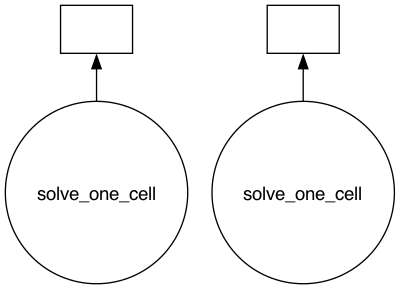

In [34]:
# Dispatch one task per grid cell
tasks = [solve_one_cell(i,temperatures,pressures,concentrations, sim_length, time_step_length) for i in range(num_grid_cells)]
# visualize the Dask graph
results = compute(*tasks)
dask.visualize(*tasks)

## 6. Visualizing Results

As in the [Multiple Grid Cells Tutorial](1.%20multiple_grid_cells.ipynb), the results can now be visualized over time and are consistent with those obtained without using Dask.

,CONC.A.mol m-3,CONC.B.mol m-3,CONC.C.mol m-3,time.s
0,5.0,5.0,5.0,0.0
1,4.976428528398802,4.999944351093875,5.0236271205073235,1.0
2,4.929618429433882,4.999502304184354,5.070879266381759,2.0
3,4.860227571898497,4.998027906909858,5.141744521191641,3.0
4,4.769223461910271,4.994590343685047,5.236186194404681,4.0
5,4.657860795721631,4.988017567302154,5.3541216369762115,5.0
6,4.527652679026353,4.9769510981867855,5.49539622278686,6.0
7,4.380336435836852,4.959909340283517,5.65975422387963,7.0
8,4.217835086228851,4.935356388404806,5.846808525366342,8.0
9,4.042215685186966,4.901773090409533,6.056011224403497,9.0


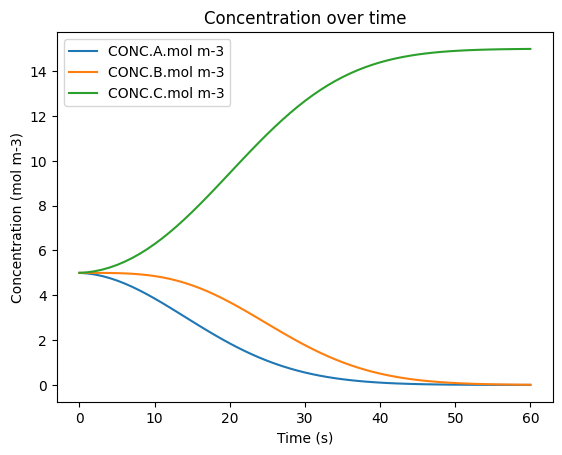

In [ ]:
# Extract the array from the tuple
time_array = results[0]['times']
data_array = results[0]['concentrations']

# Flatten the single-element lists in each dictionary
flat_dicts = [{k: v[0] for k, v in d.items()} for d in data_array]

# Convert to DataFrame
df = pd.DataFrame(flat_dicts)
df['time.s'] = data_array = results[0]['times']

#rename columns
df.rename(columns={'A': 'CONC.A.mol m-3','B':'CONC.B.mol m-3','C':'CONC.C.mol m-3'}, inplace=True)

# Show the result
# Show all rows
pd.set_option('display.max_rows', None)
display(df)

#plot
df.plot(x='time.s', y=['CONC.A.mol m-3', 'CONC.B.mol m-3', 'CONC.C.mol m-3'], title='Concentration over time', ylabel='Concentration (mol m-3)', xlabel='Time (s)')
plt.show()